In [1]:
import pandas as pd
import numpy as np

from numpy.linalg import norm
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
%matplotlib inline

Extract the different network (with different parametrizations) and use them to compute similarity between 10 seeds in the <b>finance domain</b> and the candidates, its <b>mentioned users</b>.

In [2]:
# ranking is based on distance similarity
def candidatesRanking(candidates, centroid, features):
    #centroid_v = np.array(centroid[features])
    
    output = pd.DataFrame()
    output['distance'] = candidates.apply(lambda x: norm(np.array(x[features]) - centroid), axis=1)
    output['username'] = candidates['username']
    output['similarity'] = output.apply(lambda x: 1/(1+x['distance']), axis=1)
    #output['link'] = output.apply(lambda x: 'www.twitter.com/'+x['username']+'/', axis=1)
    
    output.sort_values(by='similarity', ascending=False, inplace=True)
    
    return output[['username', 'similarity']]

In [3]:
def computeCentroid(seeds, normheader):
    arrays = [np.array(x[normheader]) for index, x in seeds.iterrows()]
    
    return np.sum(arrays, axis=0)/10

In [4]:
header = ['1','2','3','4']
normheader = ['n1','n2','n3','n4']
label = {'m': 'Mention', 'h': 'Hashtag'}

In [5]:
domain = 'finance'
path = '{}/'.format(domain)
datapath = 'data-seed/{}/'.format(domain)
candidatepath = 'data-candidates/{}/'.format(domain)

Compute the top 10 accounts for each seed and for each network type (need to validate the best one)

In [6]:
validation = pd.DataFrame()
candidates_list = list(pd.read_csv(candidatepath+'user.csv', sep='\t')['id_user'])
for graphtype in ['m','h']:
    userdata = pd.read_csv(path+'{}_reduced_nodes.csv'.format(graphtype), sep='\t') # match graph id and user instance

    for detection in ['community', 'roles']:
        print 'Graph Type: {} - {}'.format(label[graphtype], detection)
        data = pd.read_csv(path+'user_features_{}_{}.emb'.format(detection, graphtype), sep=' ', header=None, skiprows=1)

        data = userdata.merge(data, left_on='id', right_on=0)
        data.drop(0, inplace=True, axis=1)
        data.columns = ['id_graph','id_user','username','usertype','1','2','3','4']
        
        normdata = pd.DataFrame(normalize(data[header]))
        normdata.columns = normheader
        
        data = pd.concat([data, normdata], axis=1)
        
        seeds = data[data['usertype'] == 'seed']
        candidates = data[data['id_user'].isin(candidates_list)]
        centroid = computeCentroid(seeds, normheader)
        
        r = candidatesRanking(candidates, centroid, normheader)
        r.to_csv(path+'rankings/ranking_{}_{}.csv'.format(detection, graphtype[0]), index=None)

        tovalidate = r[:10]
        tovalidate['graphtype'] = '{}{}'.format(graphtype, detection)
        validation = pd.concat([validation, tovalidate])
validation['validation'] = 0
validation[['graphtype','username','similarity','validation']].to_csv(path+'validation.csv', index=None)

Graph Type: Mention - community


c:\python27\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Graph Type: Mention - roles
Graph Type: Hashtag - community
Graph Type: Hashtag - roles


Visualization of embeddings for each type, highlighting seeds, centroid and candidates

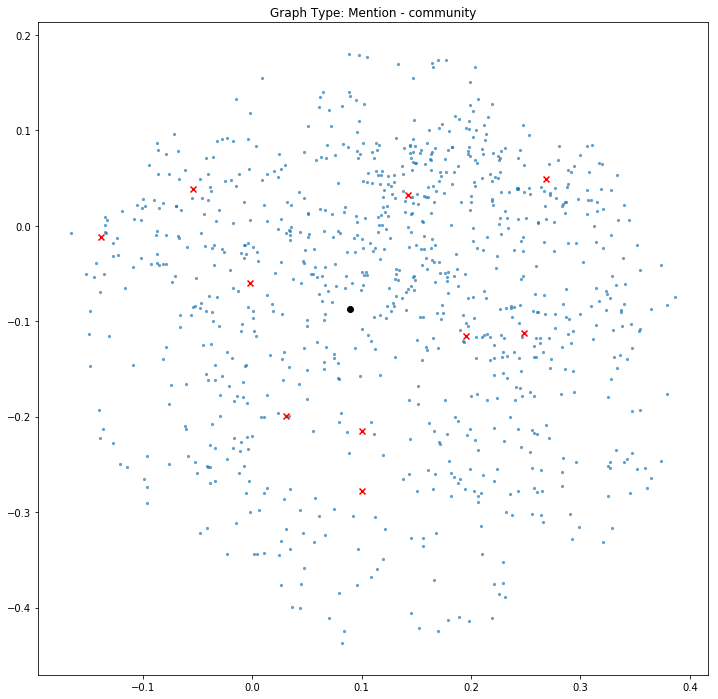

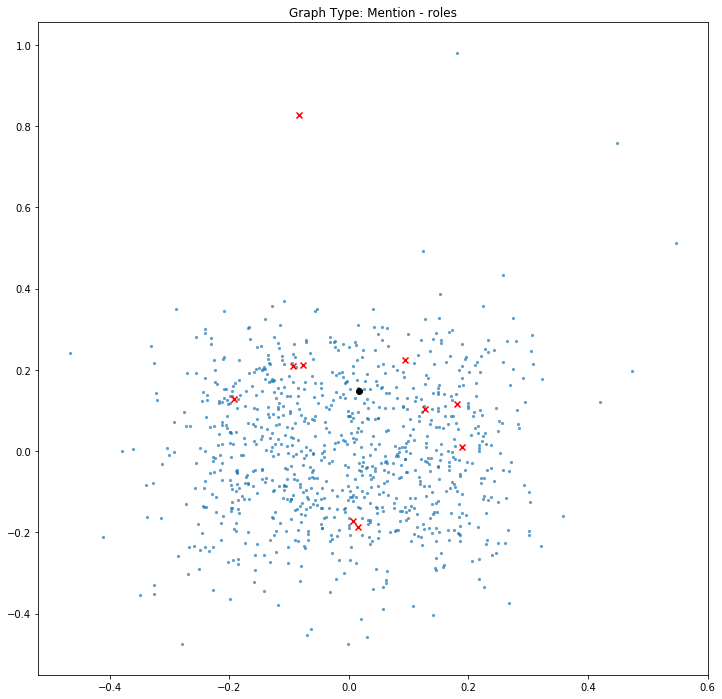

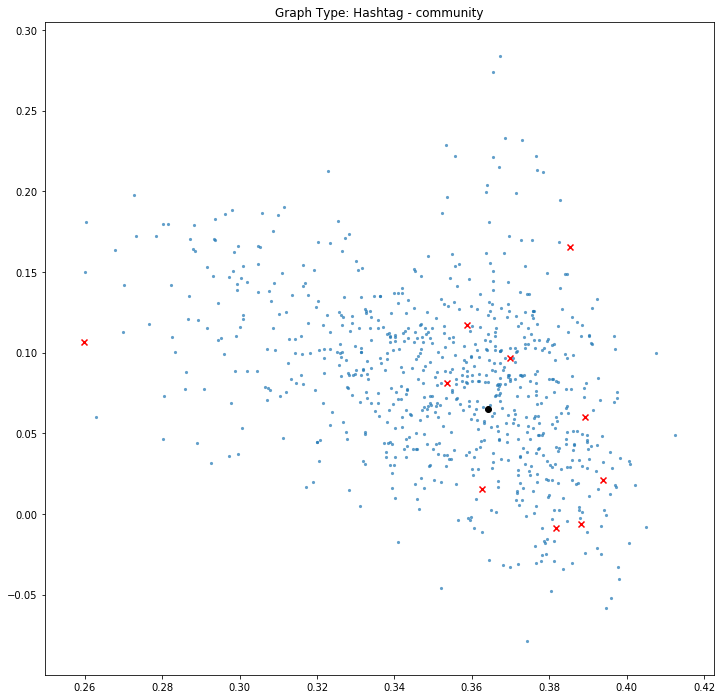

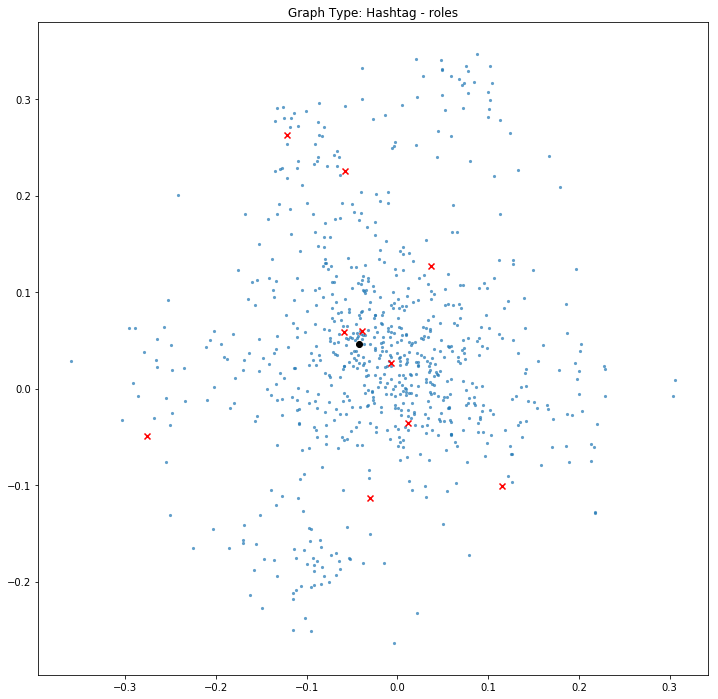

In [7]:
for graphtype in ['m','h']:
    userdata = pd.read_csv(path+'{}_reduced_nodes.csv'.format(graphtype), sep='\t') # match graph id and user instance

    for detection in ['community', 'roles']:
        data = pd.read_csv(path+'user_features_{}_{}.emb'.format(detection, graphtype), sep=' ', header=None, skiprows=1)
        data = userdata.merge(data, left_on='id', right_on=0)
        data.drop(0, inplace=True, axis=1)
        data.columns = ['id_graph','id_user','username','usertype','1','2','3','4']
        normdata = pd.DataFrame(normalize(data[header]))
        normdata.columns = ['n1','n2','n3','n4']
        
        data = pd.concat([data, normdata], axis=1)
        
        seed = data[data['usertype'] == 'seed']
        centroid = computeCentroid(seed, ['n1','n2','n3','n4'])
        candidates = data[data['id_user'].isin(candidates_list)]
        
        plt.figure(figsize=(12,12))
        plt.title('Graph Type: {} - {}'.format(label[graphtype], detection))
        
        plt.scatter(candidates['n1'], candidates['n2'], marker='.', s=40, lw=0, alpha=0.7)
        plt.scatter(seed['n1'], seed['n2'], marker='x', color='red')
        plt.scatter(centroid[0], centroid[1], color='black')

Separate analysis: <b>complete network</b> embeddings

In [17]:
c_header = ['{}'.format(i) for i in range(1,17)]
c_header_norm = ['n{}'.format(i) for i in range(1, 17)]

In [40]:
nodedata = pd.read_csv(path+'c_network_nodes.csv'.format(graphtype), sep='\t') # match graph id and user instance
data = pd.read_csv(path+'user_features_c.emb'.format(detection, graphtype), sep=' ', header=None, skiprows=1) 

In [41]:
nodedata.head()

,id,content,type,id_node
0,1,laurenlacapra,seed,36361027
1,2,2018-06-05 16:14:03,tweet,1004033619189518336
2,3,2018-06-05 14:31:07,tweet,1004007715113439240
3,4,2018-06-05 14:00:53,tweet,1004000104695595010
4,5,2018-06-05 13:58:37,tweet,1003999537579593728


In [42]:
data = data.merge(nodedata, left_on=0, right_on='id')

In [43]:
data.drop(0, inplace=True, axis=1)
data.columns = c_header+['id','username','type','id_user']

In [44]:
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,id,username,type,id_user
0,1.14333,1.09086,0.328631,-0.542904,-2.48608,0.475881,-0.638046,-0.382751,0.079702,-0.671709,-0.654149,-0.178545,1.20213,0.714872,-1.190210,-0.008376,106383,2018-05-25 19:06:06,tweet,1000090649314709509
1,1.08953,1.03976,0.365342,-0.451531,-2.31190,0.490480,-0.586992,-0.119122,0.208055,-0.577288,-0.670369,-0.373220,1.27742,0.763337,-1.108610,0.137274,213797,eholmes,user,18641695
2,1.21042,1.15870,0.276812,-0.539453,-2.50206,0.593137,-0.634189,-0.082166,0.221363,-0.684871,-0.652894,-0.211976,1.30397,0.701869,-1.020130,-0.037032,106388,2018-05-25 13:12:13,tweet,1000001592043634688
3,1.11908,1.00910,0.082921,-0.426804,-2.30818,0.628751,-0.471214,-0.149042,0.058254,-0.715963,-0.497723,-0.129261,1.29231,0.697177,-1.092460,0.072408,213799,alisonfrenz,user,21620115
4,1.11149,1.03596,0.282293,-0.395175,-2.28756,0.460220,-0.593466,-0.326523,0.316684,-0.615029,-0.747944,-0.065669,1.20277,0.680453,-0.978192,-0.049574,106322,katierosman,candidate,18083797


In [45]:
userfeatures = data[data['type'].isin(['seed','candidate','user'])]

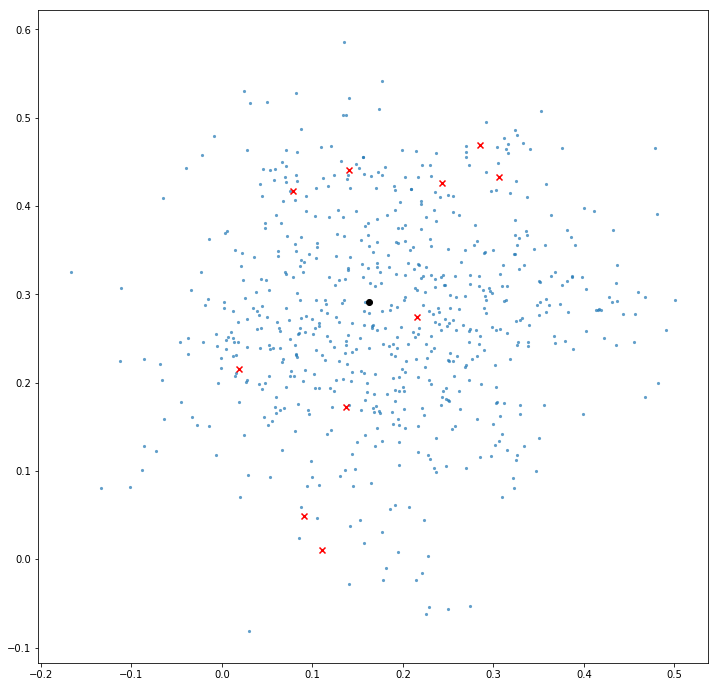

In [46]:
normdata = pd.DataFrame(normalize(userfeatures[c_header]))
normdata.columns = c_header_norm

userfeatures = pd.concat([userfeatures, normdata], axis=1)

seed = userfeatures[userfeatures['type'] == 'seed']
centroid = computeCentroid(seed, c_header_norm)
candidates = userfeatures[userfeatures['id_user'].isin(candidates_list)]

plt.figure(figsize=(12,12))
plt.scatter(candidates['n1'], candidates['n2'], marker='.', s=40, lw=0, alpha=0.7)
plt.scatter(seed['n1'], seed['n2'], marker='x', color='red')
plt.scatter(centroid[0], centroid[1], color='black')

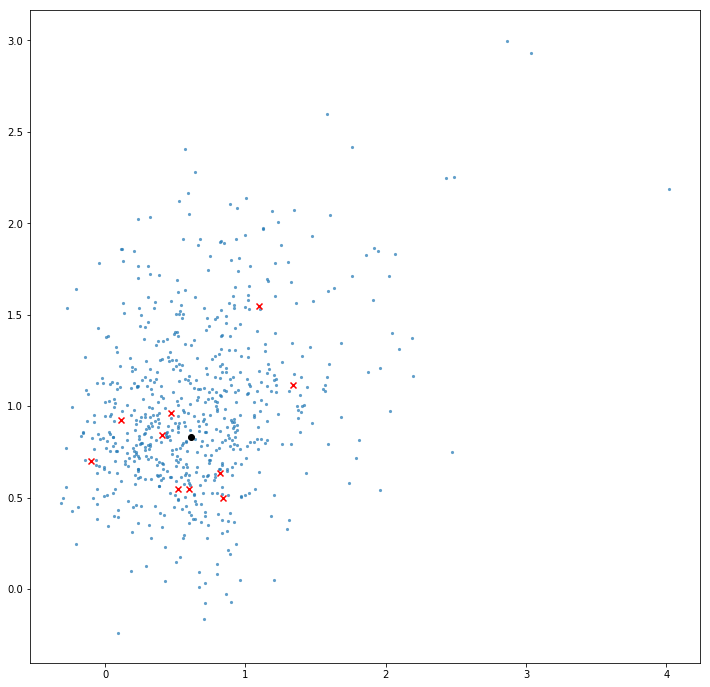

In [50]:
centroid_2 = computeCentroid(seed, c_header)

plt.figure(figsize=(12,12))
plt.scatter(candidates['1'], candidates['2'], marker='.', s=40, lw=0, alpha=0.7)
plt.scatter(seed['1'], seed['2'], marker='x', color='red')
plt.scatter(centroid_2[0], centroid_2[1], color='black')

In [51]:
r = candidatesRanking(candidates, centroid_2, c_header)
r.to_csv(path+'rankings/ranking_complete_no_norm.csv', index=None)

tovalidate = r[:10]
tovalidate['validation'] = 0
tovalidate[['username','similarity','validation']].to_csv(path+'validation_c_no_norm.csv', index=None)

c:\python27\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
